# Semi Parammetric Latent Factor Model

### Model   $Y=\phi * u + \sigma^2I$
##### Where, $\phi \in R ^{cxp}, u \in R^{pxn}$ and $Y \in R^{cxn}$
##### Also, $u_p \in GP(0,K^p)$ where $K^p$ is the covariance kernel for that particular gaussian process


In [1]:
### necessary Imports
import numpy as np
import pylab as pb
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as MNormalDist
import GPy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### True Model:

Here we generate our data that we can later use to check our solution

#### $\phi \in N(0,I)$

#### $u$
First we have similar kernels so that processes can be easily distinguished
We choose one as a exponential quad Kernel with shorter length scale.

Phi
[[-0.16493255  1.22231895]
 [-0.6913892   3.69666523]
 [ 0.0736791   1.06383011]]


<matplotlib.colorbar.Colorbar instance at 0x7fc8d679dfc8>

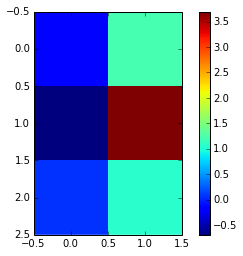

In [122]:
P = 2
C = 3
N = 5
s2 = 0.5
x = np.linspace(0,N-1,N)
phi = np.random.normal(loc=2.5,scale=2,size=(C,P))
print "Phi\n",phi
plt.imshow(phi,interpolation='none')
plt.colorbar()

In [66]:
x

array([ 0.,  1.,  2.,  3.,  4.])

<matplotlib.colorbar.Colorbar instance at 0x7fc8d69a6950>

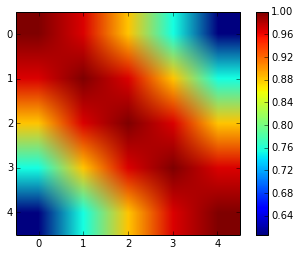

In [123]:
class Kernel:
    @staticmethod
    def exponenQuad(x,xprime,a=1,l=0.5,**kwargs):
        if kwargs:
            if kwargs['a']:
                a = kwargs['a']
            if kwargs['l']:
                l = kwargs['l'] 
        return a*np.exp((-0.5*(x - xprime)**2)/l**2)
    @staticmethod
    def generateKernel(kernelFunc,x,xprime,**kwargs):
        kernel = np.zeros((x.size,xprime.size))
        for i in range(x.size):
            for j in range(xprime.size):
                kernel[i,j] = kernelFunc(x[i],xprime[j],**kwargs)
        return np.mat(kernel)
K = list()
K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=4))
K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=1))
imshow(K[0],interpolation=None)       
plt.colorbar()

matrix([[ 1.        ,  0.96923323,  0.8824969 ,  0.7548396 ,  0.60653066],
        [ 0.96923323,  1.        ,  0.96923323,  0.8824969 ,  0.7548396 ],
        [ 0.8824969 ,  0.96923323,  1.        ,  0.96923323,  0.8824969 ],
        [ 0.7548396 ,  0.8824969 ,  0.96923323,  1.        ,  0.96923323],
        [ 0.60653066,  0.7548396 ,  0.8824969 ,  0.96923323,  1.        ]])

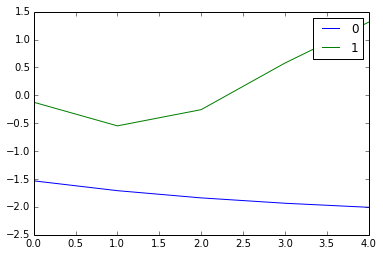

In [124]:
#Latent Gaussian Processes:
u = np.zeros((P,N))
for p in range(P):
    u[p,:] = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=K[p])
    plt.plot(u[p,:],label=p)
plt.legend()

In [125]:
# Output Values:
s2 = 0
Y = phi.dot(u) + s2


In [126]:
Y

array([[ 0.10095785, -0.38754591, -0.0117253 ,  1.0237653 ,  1.93172882],
       [ 0.60053987, -0.84291372,  0.31859158,  3.46871939,  6.22867297],
       [-0.24512101, -0.70855673, -0.40956254,  0.47080951,  1.24525841]])

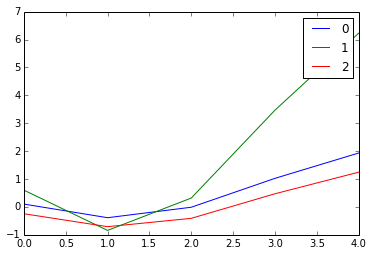

In [127]:
for c in range(C):
    plt.plot(Y[c,:],label=c)
plt.legend()

## Now objective is to variationally approximate and recover Phi 

Variational Inducing Updates are:


In [128]:
## get random inducing point
## Intialization for variational inference
P=2
noOfInductions = 3
n = sort(np.random.choice(x,size=noOfInductions,replace=False))
sparseY = np.mat(Y[:,n.astype(int)])
# Create Matrices
Knn = list()
KNn = list()
KnnInv = list()
KNN = list()
for i in range(P):
    Knn.append(Kernel.generateKernel(Kernel.exponenQuad,n,n,l=1,a=1))
    KNn.append(Kernel.generateKernel(Kernel.exponenQuad,x,n,l=1,a=1))
    KNN.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=1,a=1))
    KnnInv.append(np.linalg.inv(Knn[i]))
    print KNn[i].shape,Knn[i].shape,KnnInv[i].shape
# Generate a guess for phi
phiHatMean = 0
phiHatV = 1
phiHatExp = np.random.normal(loc=phiHatMean,scale=phiHatV,size=(C,P))
uHatMeans = np.random.normal(loc=0,scale=1,size=(P,noOfInductions,1))
uHatVs = [np.ones((noOfInductions,noOfInductions))for p in range(P)]
uExp = np.random.normal(loc=0,scale=1,size=(P,N))

(5, 3) (3, 3) (3, 3)
(5, 3) (3, 3) (3, 3)


In [129]:
uExp

array([[ 0.28452896,  0.78594148, -0.70677188, -0.20455853,  0.85883971],
       [ 2.03286339,  1.468678  ,  0.62805406, -1.40014362, -1.36711702]])

### Initial Guesses:
    

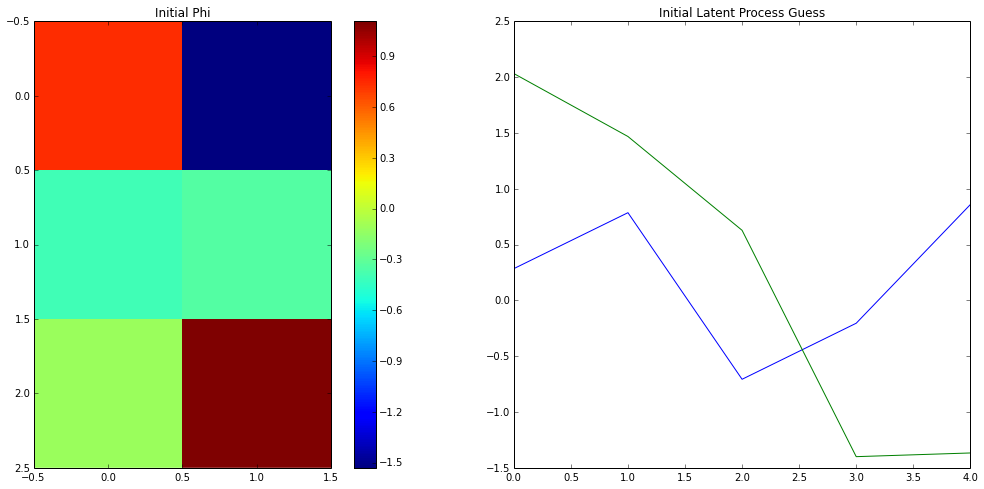

In [130]:
def displayGuesses(phiHatExp,uExp):
    fig,axes = plt.subplots(nrows = 1,ncols = 2, figsize=(18,8))
    im = axes[0].imshow(phiHatExp,interpolation='None')
    plt.colorbar(im,ax=axes[0])
    axes[0].set_title("Initial Phi")

    for p in range(P):
        axes[1].plot(x,uExp[p])
        axes[1].set_title("Initial Latent Process Guess")
displayGuesses(phiHatExp,uExp)

### Variational Updates are:

#### For U's:

$$\hat{u}_p = N(\Sigma_{p}^{-1}K_{n}^{-1}K_{Nn}Z_p,\Sigma_{p})$$
where $\Sigma_{p} = K_{n}^{-1} + \frac{1}{\sigma^2}K_{n}^{-1}K_{nN}UK_{Nn}K_{n}^{-1}$
and $Z_p = \sum_{c}^{C}<\phi_{cp}>(y_c - \sum_{i}^{P/p}<\phi_{ci}><u_{ip}>)$, 
and $U_p = \sum_{c}^{C}<\phi_{cp}^2>$

$<\phi_{cp}^2> = var(\phi_{cp}) - <\phi_{cp}>^2$ 


Also,Actual U is:

E[u] = $K_{Nn}K_{n}^{-1}\hat{\mu}_{p}$
where $\hat{\mu}_{p}$ is the mean of $\hat{u}_p$

#### For $\phi$:

$\phi = N(yU^{T}\Sigma_{\phi}^{-1}, \Sigma{f}^{-1})$
where $\Sigma_{\phi} = (V_{\phi}^{-1} + I )$
and $V_{\phi} = <U><U>^T\sigma^2$

### And lower bound of liklelihood with respect to $u_p$ is given by:

$L(u_p) = log N(U_{p}^{-1}z_p| 0, U_{p}^{-1} + K_{Nn}K_{nn}^{-1}K_{nN}) - \frac{1}{2}tr(\sum_{i}^{P}{U_i*cov(u_i|\hat{u_i}}))$ - KL divergence terms.. 

where
$ cov(u_p|\hat{u}_p) = K_N - K_{Nn}K_{n}^{-1}K_{nN}$

#### uP

$cov(u_p| \hat{u_p}) = K_{N} - K_{Nn}K_{n}^{-1}K{Nn}$


-9.46272070675e+12


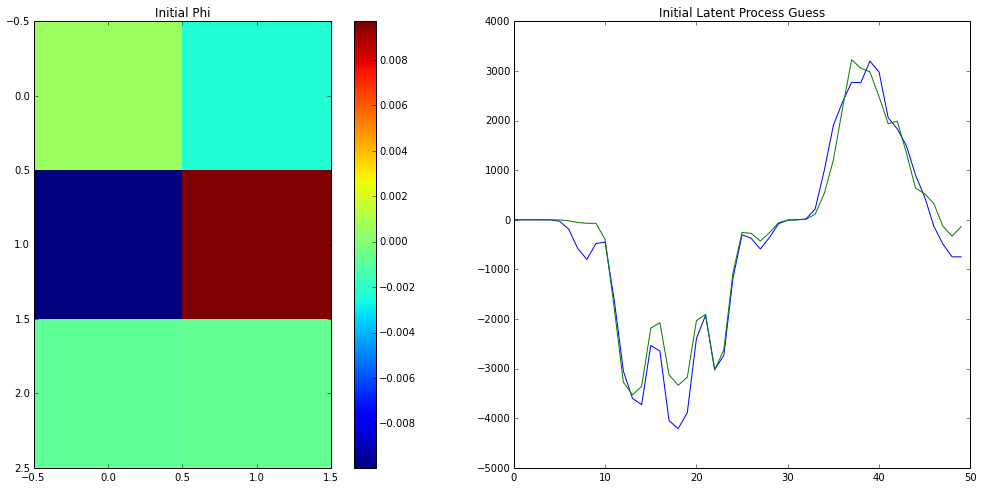

In [50]:
print calculateLikelihood(Up,Zp,0)
displayGuesses(uExp=uExp,phiHatExp=phiHatExp)

In [110]:
def calculateLikelihood(Up,Zp,p):
    uInv = np.linalg.inv(Up[p])
    covMul = KNn[p]*KnnInv[p]*KNn[p].T
    logNterm = sum(MNormalDist.logpdf(x=uInv*Zp[p].T, mean=  np.zeros((50)),cov=uInv +covMul )) 
    summationForTrace = np.zeros((N,N))
    for i in range(P):
        covUiHat = KNN[i] - KNn[i]*KnnInv[i]*KNn[i].T
        summationForTrace += Up[i]*covUiHat
    likl = logNterm - 0.5*np.matrix.trace(summationForTrace) 
    return likl

In [115]:
Up = list()
Zp = list()
for i in range(1):
    ## Variation Update for Phi
    Vf= uExp.dot(uExp.T)
    Sigmaf = np.mat(Vf + np.ones((P,P)))
    SigmafInv = np.linalg.inv(Sigmaf)
    phiHatExp = np.mat(Y) * uExp.T * SigmafInv
    phiHatVar = SigmafInv 
    ## Variation Update for Up:
    for p in range(P):
        #Find Up and Zp
        #Find summation terms
        Zp.append(np.mat(np.zeros((1,N))))
        Up.append(np.zeros((N,N)))
        excludeP = np.arange(P)!=p
        UpTerm = 0
        for c in range(C):
            errTerm = Y[c,:] - phiHatExp[c,excludeP].dot(uExp[excludeP,:])
            #print errTerm.shape
            Zp[p] += phiHatExp[c,p] * errTerm
            UpTerm += phiHatVar[p,p] + phiHatExp[c,p]**2
        Up[p] = np.diag(np.ones(N)*UpTerm)
        #print Up
        SigmaP = KnnInv[p] + KnnInv[p] * KNn[p].T * Up[p] * KNn[p] * KnnInv[p]
        uHatMeans[p] = (np.linalg.inv(SigmaP)*KnnInv[p]*KNn[p].T*Zp[p].T).reshape(noOfInductions,1)
        uExp[p] = (KNn[p]*KnnInv[p]*uHatMeans[p]).reshape(1,N)


In [81]:
for i in range(1,2000):
    #print str(i)+" Variational Update\n"
    if i%5000 == 0:
        displayGuesses(phiHatExp,uExp)   
        plt.show()
    ## Variation Update for Phi
    Vf= uExp.dot(uExp.T)
    Sigmaf = np.mat(Vf + np.ones((P,P)))
    SigmafInv = np.linalg.inv(Sigmaf)
    phiHatExp = np.mat(Y) * uExp.T * SigmafInv
    phiHatVar = SigmafInv 
    ## Variation Update for Up:
    for p in range(P):
        #Find Up and Zp
        #Find summation terms
        Zp = np.mat(np.zeros((1,N)))
        Up = 0
        excludeP = np.arange(P)!=p
        for c in range(C):
            errTerm = Y[c,:] - phiHatExp[c,excludeP].dot(uExp[excludeP,:])
            #print errTerm.shape
            Zp += phiHatExp[c,p] * errTerm
            Up += phiHatVar[p,p] + phiHatExp[c,p]**2
        Up = np.diag(np.ones(N)*Up)
        #print Up
        SigmaP = KnnInv[p] + KnnInv[p] * KNn[p].T * Up * KNn[p] * KnnInv[p]
        uHatMeans[p] = (np.linalg.inv(SigmaP)*KnnInv[p]*KNn[p].T*Zp.T).reshape(noOfInductions,1)
        uExp[p] = (KNn[p]*KnnInv[p]*uHatMeans[p]).reshape(1,N)


In [83]:
Y = phiHatExp*uExp

In [131]:
Vf = uExp.dot(uExp.T)
    

In [112]:
Sf = np.linalg.inv(Vf)+ np.ones((2,2))
Sf 

array([[ 2.03802567,  1.34010754],
       [ 1.34010754,  1.32635489]])

In [121]:
np.mat(Y) * (uExp.T.dot(Sf))


matrix([[-121.06719665,  -61.75053341],
        [-102.70204248,  -54.73702836],
        [ -98.57783009,  -52.74577126]])

In [116]:
phiHatExp

matrix([[-2.04129776,  4.75769769],
        [-2.72434146,  3.80095856],
        [-2.70216975,  3.62767116]])

In [114]:
uExp

array([[ 0.15541363, -1.14790487,  0.11584469, -0.08208878, -0.31761031],
       [ 0.8367871 ,  1.38948242,  0.84947795, -0.88028957,  0.72492445]])

In [117]:
uExp

array([[-2.99845375, -0.74084784, -2.21832938, -2.28190782, -0.60758936],
       [ 1.26096779,  1.50146389,  0.58508206, -0.01550615, -0.03230913]])

In [317]:
print np.linalg.inv(SigmaP).shape,KnnInv[p].shape,KnN[p].shape,Zp.T.shape

(20, 20) (20, 20) (20, 50) (20, 1)


In [311]:
Yhat = Y[:,n.astype(int)]

In [312]:
Yhat

array([[ 1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.54891182,
         1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.54891182,
         1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.66628876,
         1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.54891182],
       [ 1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.75082811,
         1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.75082811,
         1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.70976584,
         1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.75082811],
       [-1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.28455901,
        -1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.28455901,
        -1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.99535756,
        -1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.28455901]])